# Ground state (edge) moves

In [1]:
import numpy as np
import bisect
import matplotlib.pyplot as plt
import pimc # custom module
from scipy.stats import truncexpon

### Simulation parameters

In [2]:
# Simulation parameters
N = 2
L = N*2   # half-filling
t = 0
U = 0.5
mu = -0.1
    
# PIMC parameters
beta = 1
eta = 1/np.sqrt(L*beta)      # worm end fugacity

### Create a worldline configuration 

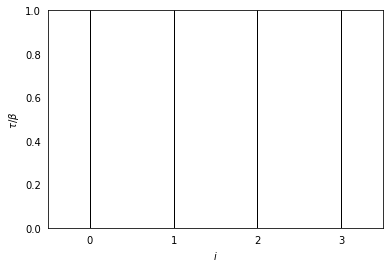

In [3]:
# Create a worldline configuration
alpha = [1,1,1,1]
data_struct = pimc.create_data_struct(alpha)
head_loc = []
tail_loc = []
pimc.view_worldlines(data_struct,beta,figure_name=None)

## Insert a worm or antiworm from $\tau=0$

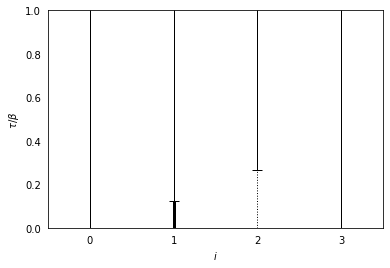

head_loc:  [1, 1]
tail_loc:  [2, 1]


In [4]:
# Create a worldline configuration
alpha = [1,1,1,1]
data_struct = pimc.create_data_struct(alpha)
head_loc = []
tail_loc = []

pimc.insert_gsworm_zero(data_struct,beta,head_loc,tail_loc,U,mu,eta)
pimc.insert_gsworm_zero(data_struct,beta,head_loc,tail_loc,U,mu,eta)

pimc.view_worldlines(data_struct,beta,figure_name=None)
print("head_loc: ",head_loc)
print("tail_loc: ",tail_loc)

### Just a (slightly) more complex configuration

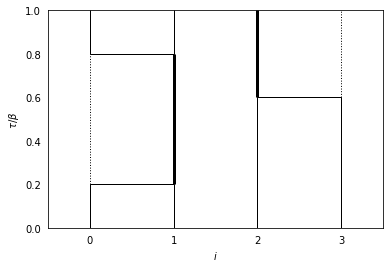

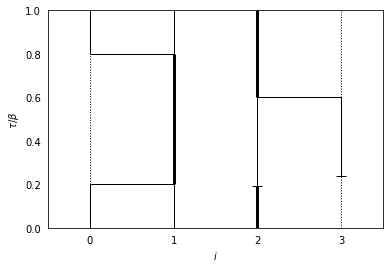

head_loc:  [2, 1]
tail_loc:  [3, 1]


In [5]:
data_struct = []
x1 = [[0,1,(0,0)],[0.2,0,(0,1)],[0.8,1,(1,0)]]
x2 = [[0,1,(1,1)],[0.2,2,(0,1)],[0.8,1,(1,0)]]
x3 = [[0,1,(2,2)],[0.6,2,(3,2)]]
x4 = [[0,1,(3,3)],[0.6,0,(3,2)]]
data_struct.append(x1)
data_struct.append(x2)
data_struct.append(x3)
data_struct.append(x4)
pimc.view_worldlines(data_struct,beta,figure_name=None)

head_loc = []
tail_loc = []

pimc.insert_gsworm_zero(data_struct,beta,head_loc,tail_loc,U,mu,eta)
pimc.insert_gsworm_zero(data_struct,beta,head_loc,tail_loc,U,mu,eta)

pimc.view_worldlines(data_struct,beta,figure_name=None)
print("head_loc: ",head_loc)
print("tail_loc: ",tail_loc)

## Insert a worm or antiworm from $\tau=\beta$

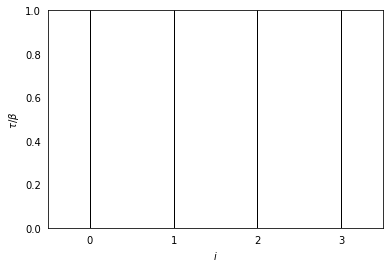

In [6]:
# Create a worldline configuration
alpha = [1,1,1,1]
data_struct = pimc.create_data_struct(alpha)
head_loc = []
tail_loc = []
pimc.view_worldlines(data_struct,beta,figure_name=None)

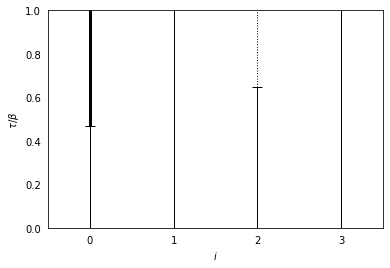

head_loc:  [2, 1]
tail_loc:  [0, 1]


In [7]:
# Create a worldline configuration
alpha = [1,1,1,1]
data_struct = pimc.create_data_struct(alpha)
head_loc = []
tail_loc = []

pimc.insert_gsworm_beta(data_struct,beta,head_loc,tail_loc,U,mu,eta)
pimc.insert_gsworm_beta(data_struct,beta,head_loc,tail_loc,U,mu,eta)

pimc.view_worldlines(data_struct,beta,figure_name=None)
print("head_loc: ",head_loc)
print("tail_loc: ",tail_loc)

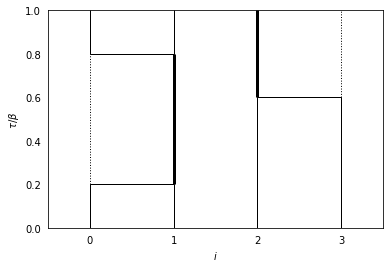

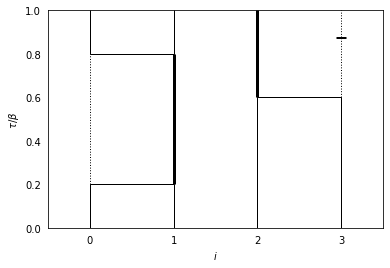

head_loc:  [3, 1]
tail_loc:  [3, 1]


In [8]:
# More complex configuration
data_struct = []
x1 = [[0,1,(0,0)],[0.2,0,(0,1)],[0.8,1,(1,0)]]
x2 = [[0,1,(1,1)],[0.2,2,(0,1)],[0.8,1,(1,0)]]
x3 = [[0,1,(2,2)],[0.6,2,(3,2)]]
x4 = [[0,1,(3,3)],[0.6,0,(3,2)]]
data_struct.append(x1)
data_struct.append(x2)
data_struct.append(x3)
data_struct.append(x4)
pimc.view_worldlines(data_struct,beta,figure_name=None)

head_loc = []
tail_loc = []

pimc.insert_gsworm_beta(data_struct,beta,head_loc,tail_loc,U,mu,eta)
pimc.insert_gsworm_beta(data_struct,beta,head_loc,tail_loc,U,mu,eta)

pimc.view_worldlines(data_struct,beta,figure_name=None)
print("head_loc: ",head_loc)
print("tail_loc: ",tail_loc)

## Insert a worm end from $\tau=0$ and another from $\tau=\beta$

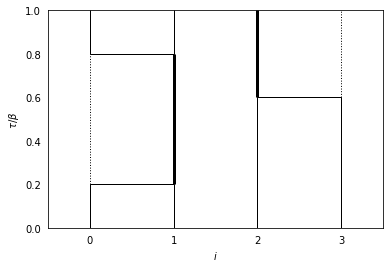

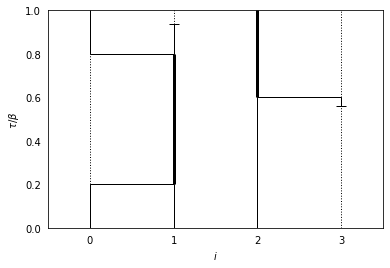

head_loc:  [1, 1]
tail_loc:  [3, 1]


In [9]:
# More complex configuration
data_struct = []
x1 = [[0,1,(0,0)],[0.2,0,(0,1)],[0.8,1,(1,0)]]
x2 = [[0,1,(1,1)],[0.2,2,(0,1)],[0.8,1,(1,0)]]
x3 = [[0,1,(2,2)],[0.6,2,(3,2)]]
x4 = [[0,1,(3,3)],[0.6,0,(3,2)]]
data_struct.append(x1)
data_struct.append(x2)
data_struct.append(x3)
data_struct.append(x4)
pimc.view_worldlines(data_struct,beta,figure_name=None)

head_loc = []
tail_loc = []

pimc.insert_gsworm_zero(data_struct,beta,head_loc,tail_loc,U,mu,eta)
pimc.insert_gsworm_beta(data_struct,beta,head_loc,tail_loc,U,mu,eta)

pimc.view_worldlines(data_struct,beta,figure_name=None)
print("head_loc: ",head_loc)
print("tail_loc: ",tail_loc)